In [1]:
import pandas as pd
import numpy as np
import os

import pickle


In [2]:
import joblib
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
from tabular_learning.datasets import TabularDataset



all_datasets = [
  'BPIC20DD',
 'BPIC20ID',
 'BPIC20PTC',
 'BPIC17',
 'BPIC15_1',
 'BPIC15_2',
 'BPIC15_3',
 'BPIC15_4',
 'BPIC15_5',
 'HelpDesk',
 ]

all_res = {}

setting = "5CV-random"

mod_list = []

for dat in all_datasets:
    print(dat)
    all_res[dat] = {}
    if not os.path.exists(f"results_compact/res_{dat}.pkl"):
    
        dataset = TabularDataset(dat)
        X = pd.read_csv(f"data/processed/{dat}/{dat}_two_TS.csv", low_memory=False)
    
        
        train_index, val_index, test_index = dataset.split_indices[0]
        # X_train = dataset.X.loc[train_index]
        # X_val = dataset.X.loc[val_index]
        # X_test = dataset.X.loc[test_index]
        
        # y_train = dataset.y.loc[train_index]
        # y_val = dataset.y.loc[val_index]
        y_test = dataset.y.loc[test_index]
        for mod in ["TabM", "CatBoost"]:
            for tune in [""]: #, "_tuned_50trials"]:
                for setting in ["5CV-random"]: 
                    mod_list.append(mod+tune+setting)
                    all_res[dat][mod+tune+setting] = {}
                    try:
                        res = joblib.load(f"results/{dat}/None_minimalistic/{mod}/{setting}{tune}/{setting}{tune}_seed42.pickle")
    
                        all_res[dat][mod+tune+setting]["predictions"] = res["predictions"]
                        
                        perfs = [mae(y_test, res["predictions"][f"seed_{seed}"][2]) for seed in range(5)]
                        
                        all_res[dat][mod+tune+setting]["mae_folds"] = perfs
                        all_res[dat][mod+tune+setting]["mae_mean"] = np.mean(perfs)
                        all_res[dat][mod+tune+setting]["mae_std"] = np.std(perfs)
    
                        perfs_larger1 = [mae(
                            y_test.loc[X[X["set"]=="Test"]["prefix_length"]>1], 
                            pd.Series(res["predictions"][f"seed_{seed}"][2],y_test.index).loc[X[X["set"]=="Test"]["prefix_length"]>1]
                        ) for seed in range(5)]
                        all_res[dat][mod+tune+setting]["mae_folds_larger1"] = perfs_larger1
                        all_res[dat][mod+tune+setting]["mae_mean_larger1"] = np.mean(perfs_larger1)
                        all_res[dat][mod+tune+setting]["mae_std_larger1"] = np.std(perfs_larger1)
                        
                        for prefix in X[X["set"]=="Test"]["prefix_length"].unique():
                            prefix_perfs = [mae(
                                y_test.loc[X[X["set"]=="Test"]["prefix_length"]==prefix], 
                                pd.Series(res["predictions"][f"seed_{seed}"][2],y_test.index).loc[X[X["set"]=="Test"]["prefix_length"]==prefix]
                            ) for seed in range(5)]
                            all_res[dat][mod+tune+setting][f"mae_folds_prefix{prefix}"] = prefix_perfs
                            all_res[dat][mod+tune+setting][f"mae_mean_prefix{prefix}"] = np.mean(prefix_perfs)
                            all_res[dat][mod+tune+setting][f"mae_std_prefix{prefix}"] = np.std(prefix_perfs)
                            
                    except:
                        for i in ["mae_folds", "mae_mean", "mae_std","mae_folds_larger1", "mae_mean_larger1", "mae_std_larger1"]+[f"mae_folds_prefix{prefix}" for prefix in X[X["set"]=="Test"]["prefix_length"].unique()]+[f"mae_mean_prefix{prefix}" for prefix in X[X["set"]=="Test"]["prefix_length"].unique()]+[f"mae_std_prefix{prefix}" for prefix in X[X["set"]=="Test"]["prefix_length"].unique()]:
                            all_res[dat][mod+tune+setting][i] = np.nan
    
        with open(f"results_compact/res_{dat}.pkl", 'wb') as f:
            pickle.dump(all_res, f, pickle.HIGHEST_PROTOCOL)
    else:
        with open(f"results_compact/res_{dat}.pkl", 'rb') as f:
            all_res = pickle.load(f)
            


BPIC20DD
BPIC20ID
BPIC20PTC
BPIC17
BPIC15_1
BPIC15_2
BPIC15_3
BPIC15_4
BPIC15_5
HelpDesk


In [3]:
means_paper = pd.DataFrame({dat: {mod: all_res[dat][mod]["mae_mean_larger1"] for mod in ["TabM5CV-random", "CatBoost5CV-random"]} for dat in all_datasets}).transpose()
stds_paper = pd.DataFrame({dat: {mod: all_res[dat][mod]["mae_std_larger1"] for mod in ["TabM5CV-random", "CatBoost5CV-random"]} for dat in all_datasets}).transpose()
means_paper.round(2).astype(str) + " (" + stds_paper.round(2).astype(str) + ")"

,TabM5CV-random,CatBoost5CV-random
BPIC20DD,2.98 (0.04),3.02 (0.02)
BPIC20ID,12.07 (0.21),14.65 (0.29)
BPIC20PTC,7.08 (0.18),8.66 (0.19)
BPIC17,7.35 (0.11),7.48 (0.03)
BPIC15_1,16.75 (0.21),25.09 (0.72)
BPIC15_2,25.89 (0.56),47.31 (2.98)
BPIC15_3,15.12 (0.56),18.74 (0.74)
BPIC15_4,38.26 (1.43),47.06 (1.94)
BPIC15_5,23.25 (0.6),39.68 (3.45)
HelpDesk,4.95 (0.25),4.81 (0.07)


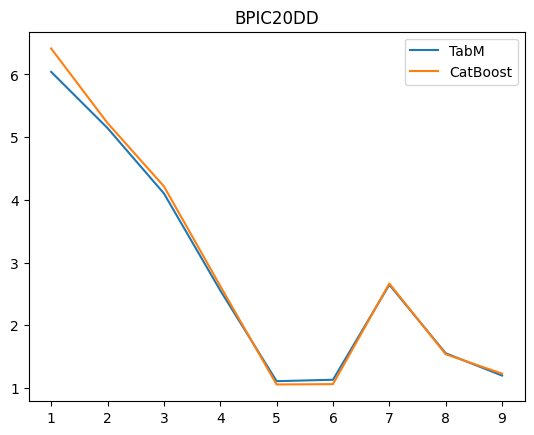

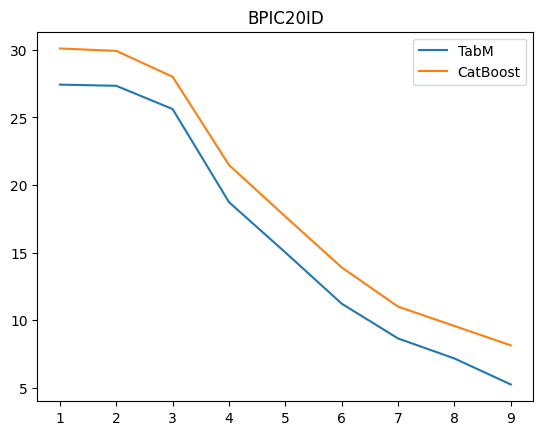

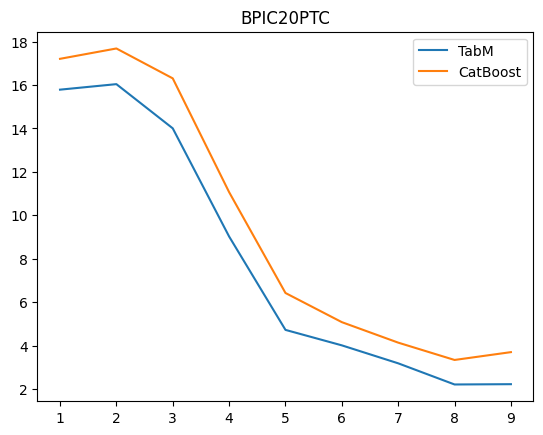

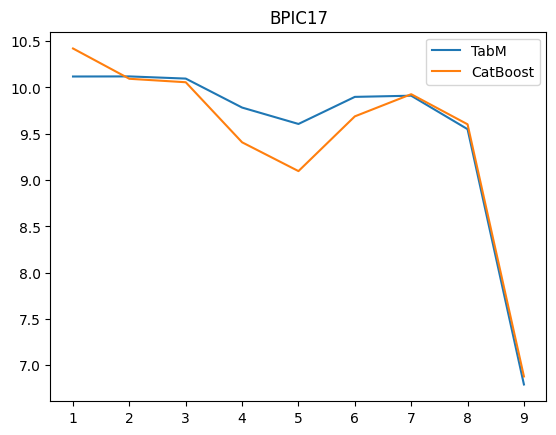

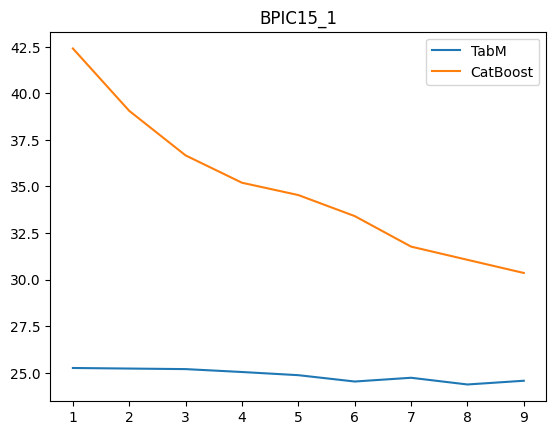

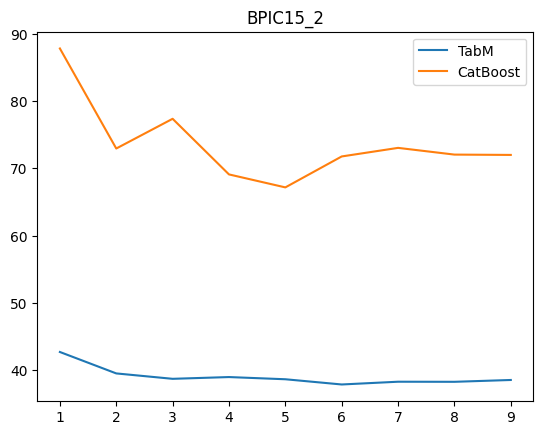

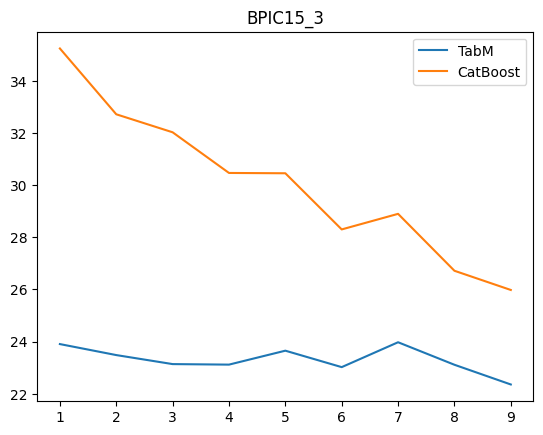

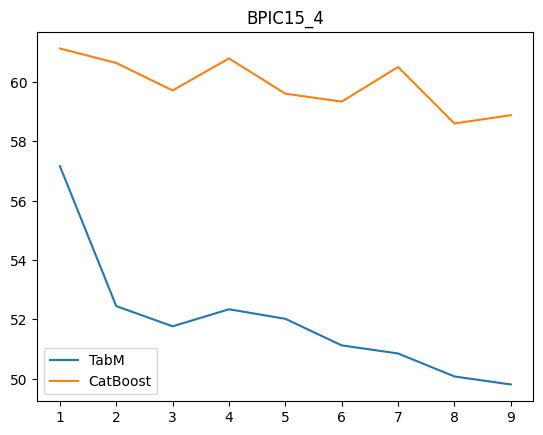

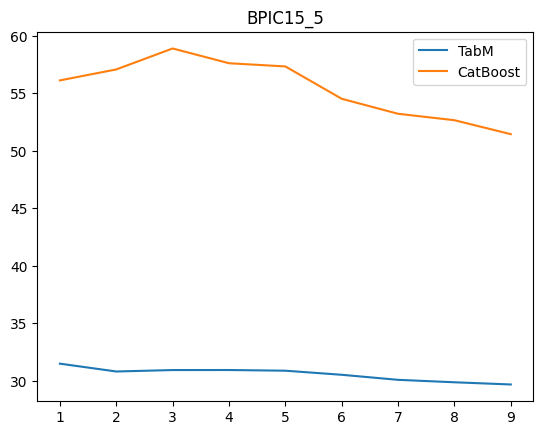

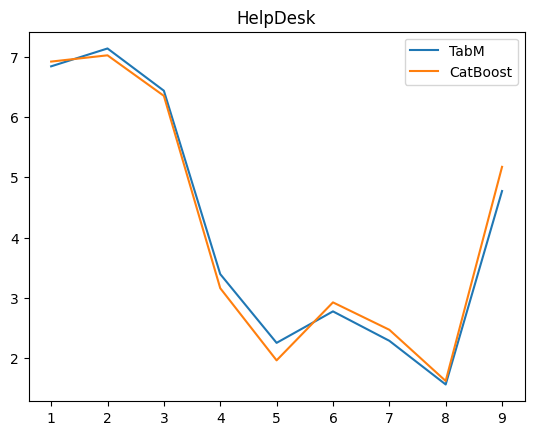

In [4]:
import matplotlib.pyplot as plt

for dat in all_datasets:
    lst = []
    for prefix in range(1,10):
        lst.append(pd.DataFrame({dat: {mod: all_res[dat][mod][f"mae_mean_prefix{prefix}"] for mod in ["TabM5CV-random", "CatBoost5CV-random"]} for dat in [dat]}).values)
    
    plt.plot(range(1, len(lst)+1), np.array(lst)[:,:,-1])
    plt.title(dat)
    plt.legend(["TabM", "CatBoost"])
    plt.show()